# MA4402 Proyecto final 2025
## Internal DLA con branching random walk
## Integrantes

- Francisco Loyola
- Pascal Steiner

# IMPORTACIONES

In [25]:
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image, display
import time

# CLASE:

In [26]:
movimientos = ((1,0), (-1,0), (0,1), (0,-1))

def exp(tasa):
    return np.random.exponential(1.0 / tasa)

class BRW:
    def __init__(self, tasa_salto, tasa_rep, prob_vivir, posiciones):
        self.tasa_rep = float(tasa_rep)
        self.tasa_salto = float(tasa_salto)
        self.t = 0.0
        self.prob_vivir = float(prob_vivir)
        if posiciones is None:
            posiciones = [(0, 0)]
        self.posiciones = list(posiciones)
        self.cemento = set(self.posiciones)
        self.reinicios = 0

    def reproducir_morir(self):
        particulas = len(self.posiciones)
        if particulas == 0:
            return self.posiciones
        particula = random.randint(0, particulas - 1)
        u = random.uniform(0, 1)

        if u < self.prob_vivir:
            x, y = self.posiciones[particula]
            ocupadas = set(self.posiciones)
            vecinos = [(x + i, y + j) for (i, j) in movimientos]
            vecinos_libres = [v for v in vecinos if v not in ocupadas]
            if not vecinos_libres:
                return self.posiciones
            nueva_pos = random.choice(vecinos_libres)
            if nueva_pos in self.cemento:
                self.posiciones.append(nueva_pos)
            else:
                self.cemento.add(nueva_pos)

            return self.posiciones
        else:
            self.posiciones.pop(particula)
            return self.posiciones



    def saltar(self):
        particulas = len(self.posiciones)
        if particulas == 0:
            return self.posiciones
        else:
            particula = random.randint(0, particulas - 1)
            movimiento = random.randint(0, 3)
            i, j = movimientos[movimiento]
            x, y = self.posiciones[particula]
            nueva_pos = (x + i, y + j)

            if nueva_pos not in self.cemento:
                self.cemento.add(nueva_pos)
                self.posiciones.pop(particula)
            else:
                self.posiciones[particula] = nueva_pos

            return self.posiciones

    def avanza(self):
        particulas = len(self.posiciones)
        if particulas == 0:
            return self.posiciones
        u = random.uniform(0,1)
        if u < self.tasa_salto/(self.tasa_salto + self.tasa_rep):
            return self.saltar()
        else:
            return self.reproducir_morir()
     
    def avanzar(self):
        particulas = len(self.posiciones)
        if particulas == 0:
            self.posiciones.append((0, 0))
            self.cemento.add((0, 0))
            self.reinicios += 1
            return self.posiciones

        tasa_total   = particulas * (self.tasa_salto + self.tasa_rep)
        self.t += exp(tasa_total)
        self.avanza()
        return self.posiciones


# FUNCION ANIMADORA:

In [27]:
def simular_cemento(brw, n_frames,t_inicial=1.0,factor=1.2,max_tiempo_real_seg=None):
    trayectoria_cemento = []
    t0_real = time.time()

    target_t = 0.0
    delta_t  = t_inicial

    for k in range(n_frames):
        if max_tiempo_real_seg is not None:
            if time.time() - t0_real > max_tiempo_real_seg:
                break

        while brw.t < target_t:
            if max_tiempo_real_seg is not None:
                if time.time() - t0_real > max_tiempo_real_seg:
                    return trayectoria_cemento
            brw.avanzar()

        trayectoria_cemento.append((list(brw.cemento), brw.t, brw.reinicios))

        target_t += delta_t
        delta_t *= factor

    return trayectoria_cemento


def animar_cemento(trayectoria_cemento, prob_vivir, tasa_rep,interval_ms=200, zoom_dinamico=True):
    fig, ax = plt.subplots()
    scat = ax.scatter([], [], s=5)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', alpha=0.3)

   # radio para cada snapshot (norma infinito)
    radios = []
    for pos, t, reinicios in trayectoria_cemento:
        if pos:
            max_x = max(abs(x) for x, y in pos)
            max_y = max(abs(y) for x, y in pos)
            r = max(max_x, max_y)
        else:
            r = 1.0
        radios.append(r)

    def update(k):
        pos, t, reinicios = trayectoria_cemento[k]
        xs = [x for x, y in pos]
        ys = [y for x, y in pos]

        if xs:
            offsets = np.column_stack([xs, ys])
        else:
            offsets = np.empty((0, 2))

        scat.set_offsets(offsets)

        R = max(radios[:k+1])
        R = max(R, 1.0)
        ax.set_xlim(-R - 1, R + 1)
        ax.set_ylim(-R - 1, R + 1)

        ax.set_title(f"IDLA–BRW | λ_rep = {tasa_rep}, p_vivir = {prob_vivir}, reinicios = {reinicios}")
        return scat,

    ani = FuncAnimation(
        fig, update,
        frames=len(trayectoria_cemento),
        interval=interval_ms,
        blit=False,
        repeat=False
    )
    return ani


# SIMULACION:

In [ ]:
tiempo = 60*60                  #3*60*60 son 3 horas de tiempo real de simulación
prob_vivir = 0.5
tasa_rep   = 0.1
brw = BRW(1.0, tasa_rep, prob_vivir, None)

n_frames = 400
tray_cem = simular_cemento(brw,n_frames=n_frames,t_inicial=1.0,factor=1.2, max_tiempo_real_seg=tiempo)


ani = animar_cemento(tray_cem,prob_vivir=prob_vivir,tasa_rep=tasa_rep,interval_ms=100,zoom_dinamico=True)
ani.save("cemento_largo.gif", writer=PillowWriter(fps=10))
plt.close(ani._fig)
display(Image(filename="cemento_largo.gif"))

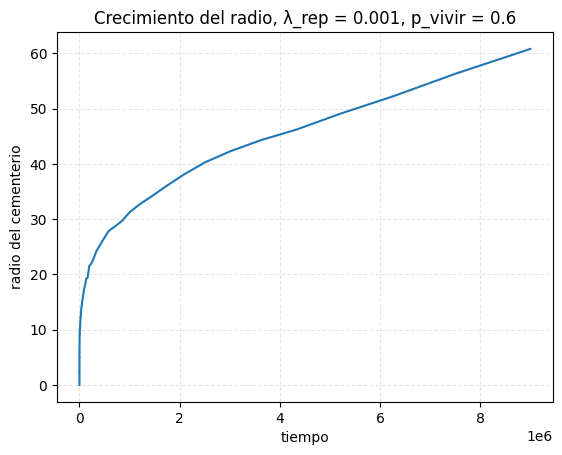

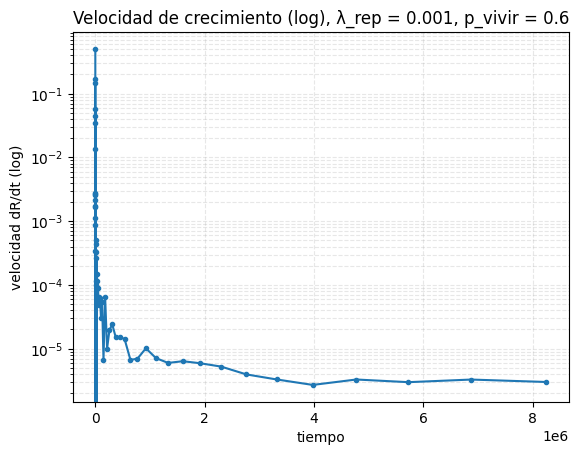

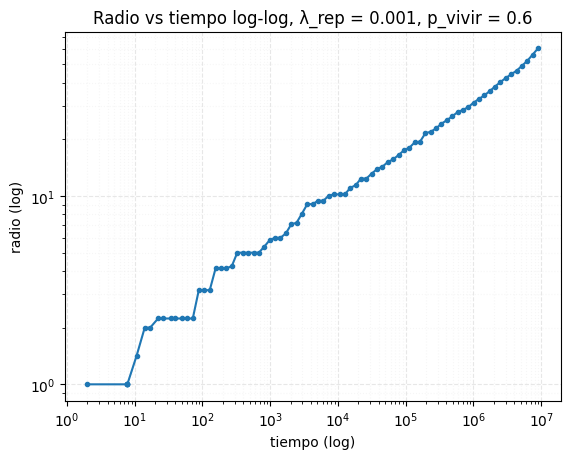

In [ ]:
def radios_cemento(trayectoria_cemento, norma="euclidea"):
    tiempos = []
    radios  = []

    for pos, t, _ in trayectoria_cemento:   # ignoramos reinicios
        tiempos.append(t)
        if not pos:
            radios.append(0.0)
            continue

        if norma == "euclidea":
            r = max((x*x + y*y)**0.5 for (x, y) in pos)
        elif norma == "infinito":
            r = max(max(abs(x), abs(y)) for (x, y) in pos)
        else:
            raise ValueError("norma debe ser 'euclidea' o 'infinito'")

        radios.append(r)

    return np.array(tiempos), np.array(radios)
ts, rs = radios_cemento(tray_cem, norma="euclidea")

plt.figure()
plt.plot(ts, rs)
plt.xlabel("tiempo")
plt.ylabel("radio del cementerio")
plt.title(f"Crecimiento del radio, λ_rep = {tasa_rep}, p_vivir = {prob_vivir}")
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

ts = np.array(ts)
rs = np.array(rs)


bloque = 5 

t_prom = []
v_prom = []

n = len(rs)
for k in range(0, n-1, bloque):
    j = min(k + bloque, n-1)  
    dt = ts[j] - ts[k]
    dR = rs[j] - rs[k]
    if dt > 0:
        t_prom.append(0.5 * (ts[j] + ts[k])) 
        v_prom.append(dR / dt) 

t_prom = np.array(t_prom)
v_prom = np.array(v_prom)


plt.figure()
plt.semilogy(t_prom, v_prom, ".-")
plt.xlabel("tiempo")
plt.ylabel("velocidad dR/dt (log)")
plt.title(f"Velocidad de crecimiento (log), λ_rep = {tasa_rep}, p_vivir = {prob_vivir}")
plt.grid(True, which="both", linestyle="--", alpha=0.3)
plt.show()

plt.figure()
plt.loglog(ts[1:], rs[1:], ".-")
plt.xlabel("tiempo (log)")
plt.ylabel("radio (log)")
plt.title(f"Radio vs tiempo log-log, λ_rep = {tasa_rep}, p_vivir = {prob_vivir}")
ax = plt.gca()
ax.grid(True, which="major", linestyle="--", alpha=0.3) 
ax.grid(True, which="minor", linestyle=":",  alpha=0.1) 

plt.show()